In [1]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
from mpltools import style
from mpltools import layout
import seaborn as sns
style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.grid_search import GridSearchCV
from sklearn import cross_validation
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import *
from sklearn.linear_model import LinearRegression
from pandas_ply import install_ply, X, sym_call
install_ply(pd)
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn import naive_bayes
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sknn import mlp
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import *
from sklearn import decomposition, pipeline, metrics, grid_search
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import *
from sklearn.neural_network import BernoulliRBM
from sklearn.feature_selection import SelectKBest
from keras.models import Sequential
from keras.layers.core import *
from keras.optimizers import Adadelta
from keras.wrappers.scikit_learn import KerasClassifier

/Library/Python/2.7/site-packages/mpltools/style/__init__.py:42: FutureWarning: 

    The style-sheet functionality in mpltools has been integrated into
    Matplotlib >= 1.4. This module will be removed in a future release.

    Note that style-sheets used by `matplotlib.style` use the standard
    Matplotlib rc-file syntax instead of the INI format used by `mpltools`.
    This mostly means un-quoting strings and changing '=' to ':'.


  """, FutureWarning)
:0: FutureWarning: IPython widgets are experimental and may change in the future.


Couldn't import dot_parser, loading of dot files will not be possible.


Using Theano backend.


In [2]:
def encode_onehot(df, cols):
    """
    One-hot encoding is applied to columns specified in a pandas DataFrame.
    
    Modified from: https://gist.github.com/kljensen/5452382
    
    Details:
    
    http://en.wikipedia.org/wiki/One-hot
    http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
    
    @param df pandas DataFrame
    @param cols a list of columns to encode
    @return a DataFrame with one-hot encoding
    """
    vec = DictVectorizer()
    
    vec_data = pd.DataFrame(vec.fit_transform(df[cols].to_dict(outtype='records')).toarray())
    vec_data.columns = vec.get_feature_names()
    vec_data.index = df.index
    
    df = df.drop(cols, axis=1)
    df = pd.concat([df, vec_data], axis=1)
    return df

In [3]:
scores = ['precision', 'recall', 'f-score', 'support']
def get_cross_validation_scores(clf, X, y, n_folds=2, labels=['M', 'R'], NN=False):
    cross_validation_scores = np.zeros((len(labels) + 1, len(scores), n_folds))
    i = 0
    for train, test in StratifiedKFold(y, n_folds=n_folds):
        clf.fit(X[train], y[train])
        if NN:
            y_pred = model.predict_classes(X[test])
        else:
            y_pred = clf.predict(X[test])
        sc = precision_recall_fscore_support(y[test], y_pred, labels=labels)
        tsc = precision_recall_fscore_support(y[test], y_pred)
        for s in range(len(scores)):
            for l in range(len(labels) + 1):
                if (l == len(labels)):
                    continue
                cross_validation_scores[l][s][i] = sc[s][l]
        cross_validation_scores[len(labels)][0][i] = precision_score(y[test], y_pred)
        cross_validation_scores[len(labels)][1][i] = recall_score(y[test], y_pred)
        cross_validation_scores[len(labels)][2][i] = f1_score(y[test], y_pred)
        i += 1        
    return cross_validation_scores

def mean(x): return "%.5f" % (sum(x) / len(x))
def cross_validation_report(cv, labels):
    row_format ="{:>15}" * (len(scores) + 1)
    print row_format.format("", *scores)
    for l in range(len(labels)):
        print row_format.format(labels[l], *map(mean, cv[l]))
    cv_tr = np.zeros((len(scores)))
    for s in range(len(scores)):
        cv_tr[s] = 0.0
        for l in range(len(labels)): cv_tr[s] += float(map(mean, cv[l])[s])
    cv_tr = map(lambda x: x / len(labels), cv_tr)
    print row_format.format("total/av", *cv_tr)

In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
daily = pd.read_csv("daily_aggregate.csv")
roaming = pd.read_csv("roaming_monthly.csv")
calendar = pd.read_csv("calendar_ref.csv")
contract = pd.read_csv("contract_ref.csv")

In [5]:
def convert_gender(g):
        return {"Female": "F", "f": "F", "F": "F", "Male": "M", "m": "M", "M":"M",
                "Not Entered":"Unknown","Unknown":"Unknown"}[g]
contract["GENDER"] = contract["GENDER"].apply(convert_gender)
contract["VALUE_SEGMENT"][pd.isnull(contract["VALUE_SEGMENT"])] = "Unknown"
contract["HANDSET_NAME"][pd.isnull(contract["HANDSET_NAME"])] = "Other"
contract["AGE"][contract["AGE"] < 10] = 99
contract["AGE"][contract["AGE"] == 99] = contract["AGE"].median()
#contract["APPLE"] = contract["HANDSET_NAME"].apply(lambda x: x.lower().count("apple") > 0)
#contract = contract.drop(["HANDSET_NAME"], axis=1)
def convert_segment(s):
    return {"Core": 1, "Med-Low": 2, "Med-High": 3, "High":4,
           "Premium": 5, "Platinum": 6, "Unknown": 0}[s]
contract["VALUE_SEGMENT"] = contract["VALUE_SEGMENT"].apply(convert_segment)
contract = encode_onehot(contract, ["GENDER"])
contract["AGE_UNKNOWN"] = contract["AGE"] == 99
contract = encode_onehot(contract, ["RATE_PLAN", "HANDSET_NAME"])
# contract["APPLE"] = contract["HANDSET_NAME"].apply(lambda x: x.lower().count("apple") > 0)
# contract["GALAXY"] = contract["HANDSET_NAME"].apply(lambda x: x.lower().count("galaxy") > 0)
# contract = contract.drop(["HANDSET_NAME"], axis=1)


/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

ValueError: labels ['HANDSET_NAME'] not contained in axis

In [5]:

def feature_engineer(ds):
   
    global contract
    #ds["USAGE_MEAN"] = (ds["206_USAGE"] + ds["207_USAGE"] \
    #+ ds["208_USAGE"] + ds["209_USAGE"] + ds["210_USAGE"])  / 5.0
    cols = ["206_USAGE", "207_USAGE", "208_USAGE", "209_USAGE", "210_USAGE"]
    s_cols = ["206_SESSION_COUNT", "207_SESSION_COUNT", "208_SESSION_COUNT", "209_SESSION_COUNT", "210_SESSION_COUNT"]
    ds["OVERALL_DIFFERENCE"] = ds[cols[4]] - ds[cols[0]]
    dif_cols = ["207-206", "207-208", "208-209", "209-210"]
    s_dif_cols = ["207-206", "207-208", "208-209", "209-210"]
    #ds["210_EXCEEDS"] = ds["210_USAGE"] > 1000
    ds["209_EXCEEDS_SESSIONS"] = ds["209_USAGE"] * 1.0 / ds["209_SESSION_COUNT"] > 3.5
   
    for i in range(len(dif_cols)):
        ds[dif_cols[i]] = ds[cols[i + 1]] - ds[cols[i]]
        #ds[s_dif_cols[i]] = ds[s_cols[i + 1]] - ds[s_cols[i]]
     
    ds["OVERALL_CHANGE"] = ds["207-206"] + ds["207-208"] + ds["208-209"] + ds["209-210"] 
    res = ds.merge(contract, on=["CONTRACT_KEY"])
    # Till we know how to handle
    
    res["211_USAGE"] = (res["210_USAGE"] - res["206_USAGE"])* (5/4.0) + res["206_USAGE"] 
    res["MEAN"] = 0.0
    for m in cols:
        res["MEAN"] += res[m]
    res["MEAN"] /= 5.0
    #res["MEAN"] = res["211_USAGE"] > res["MEAN"] + 500
    res["DIFFERENCE_SIG"] = res["209-210"] > res["207-206"] + 200
    

#     session_usages = [s.split("_")[0] + "_SESSION_USAGE" for s in cols]

#     for i in range(len(s_cols)):
#         res[session_usages[i]] = res[cols[i]] * 1.0 / res[s_cols[i]]
    
#     res["SU_MEAN"] = 0
#     for m in session_usages: res["SU_MEAN"] += res[m]
#     res["SU_MEAN"] /= 5.0
#     res["211_SESSION_USAGE"] = (res["210_SESSION_USAGE"] -
#                                 res["206_SESSION_USAGE"])* (5/4.0) + res["206_SESSION_USAGE"]
#     res["SU_MEAN"] = res["211_SESSION_USAGE"] > res["SU_MEAN"] + 3
    
    
      
    res = res.drop(cols, axis=1)
#     res = res.drop(session_usages, axis=1)
    res = res.drop(s_cols, axis=1)
    
    return res

In [6]:
def feature_engineer_usage(ds):
    global contract
    cols = ["206_USAGE", "207_USAGE", "208_USAGE", "209_USAGE", "210_USAGE"]
    s_cols = ["206_SESSION_COUNT", "207_SESSION_COUNT", "208_SESSION_COUNT", "209_SESSION_COUNT", "210_SESSION_COUNT"]
    ds["211_USAGE"] = 0
    ds["211_SESSION_COUNT"] = 0
    ds["tmp"] = ''
    ds["s_tmp"] = ''
    def predict(s, m):
        vals = map(int, s.split(",")[:-1])
        reg = LinearRegression()
        t = np.array(range(0, 5))
        t.shape = (len(t), 1)
        reg.fit(t, vals)
        return reg.predict(m)
#         return np.poly1d(np.polyfit(t, vals, 3))(6)
    for i in cols: ds['tmp'] += ds[i].astype('string') + ','
    for i in s_cols: ds['s_tmp'] += ds[i].astype('string') + ','
    
    ds['211_USAGE'] = ds.apply(lambda row: predict(row['tmp'], 6), axis=1)
    ds['211_SESSION_COUNT'] = ds.apply(lambda row: predict(row['s_tmp'], 6), axis=1)
    ds["MEAN"] = 0
    ds["s_MEAN"] = 0
    for i in cols: ds["MEAN"] += ds[i]
    for i in s_cols: ds["s_MEAN"] += ds[i]
    ds["MEAN"] /= 5.0
    ds["s_MEAN"] /= 5.0
#     df = train[["CONTRACT_KEY", "211_USAGE", "MEAN","TARGET", "210_USAGE"]]
    df = ds
    df = ds.drop(["tmp","s_tmp"], axis=1)
#     df.merge(contract)
    return df

In [7]:
train_ready = train
test_ready = test

In [8]:
%timeit
train_ready = feature_engineer_usage(train)
test_ready = feature_engineer_usage(test)

In [ ]:
train_ready = train_ready.merge(contract)
test_ready = test_ready.merge(contract)

In [342]:
train_ready["NEW"] = train_ready["211_USAGE"] > 0.7 * train_ready["MEAN"] + 800

In [195]:
train_ready.keys()

Index([u'CONTRACT_KEY', u'206_SESSION_COUNT', u'206_USAGE',
       u'207_SESSION_COUNT', u'207_USAGE', u'208_SESSION_COUNT', u'208_USAGE',
       u'209_SESSION_COUNT', u'209_USAGE', u'210_SESSION_COUNT',
       ...
       u'RATE_PLAN=VF Data Solution 59', u'RATE_PLAN=VIP',
       u'RATE_PLAN=VPN Partners', u'RATE_PLAN=Vodafone Business',
       u'RATE_PLAN=Vodafone Easy', u'RATE_PLAN=Vodafone Easy 150',
       u'RATE_PLAN=Vodafone Easy 50', u'RATE_PLAN=Vodafone line bronze bundle',
       u'APPLE', u'GALAXY'],
      dtype='object', length=208)

In [9]:
def create_model():
    model = Sequential()
    model.add(Dense(64, input_dim=2, init='uniform', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
    return model

In [10]:
model = KerasClassifier(build_fn=create_model, nb_epoch=5)

In [11]:
# q = train_ready[["206_USAGE","207_USAGE","208_USAGE","209_USAGE","210_USAGE","TARGET", "CONTRACT_KEY"]]
q = train_ready[["CONTRACT_KEY", "TARGET", "211_USAGE", "MEAN"]]
#grid = GridSearchCV(estimator=model, param_grid=dict(n_estimators=ns))
X = q[(q.keys().difference(['TARGET', "CONTRACT_KEY"]))].values
y = q["TARGET"].values
#y.shape = (len(y), 1)

In [32]:
f = mlp.Classifier(
    layers=[
        mlp.Layer("Linear", units=5),
        mlp.Layer("Linear", units=5),
        mlp.Layer("Softmax")],
    learning_rate=0.002,

    n_iter=10)

In [ ]:
# svd = TruncatedSVD(n_components=200)
scl = StandardScaler()
#rbm = BernoulliRBM()
# kbst = SelectKBest(k=100)
mdl = model
# Create the pipeline 
clf = pipeline.Pipeline([('scl', scl), ('svm', mdl)])

In [ ]:
labels = [0, 1]
cv = get_cross_validation_scores(clf, X, y, labels=labels)
cross_validation_report(cv, labels)

Epoch 1/5
37710/37710 [==============================] - 2s - loss: 0.4543 - acc: 0.7991     
Epoch 2/5
27072/37710 [====================>.........] - ETA: 0s - loss: 0.4429 - acc: 0.8015

In [167]:
model = naive_bayes.GaussianNB()
model.fit(X, y)
X_test = test_ready[test_ready.keys().difference(["CONTRACT_KEY"])].values
X_test.shape
test_ready["TARGET"] = model.predict(X_test)

ValueError: Number of features of the model must  match the input. Model n_features is 2 and  input n_features is 14 

In [ ]:
model = naive_bayes.GaussianNB()
model.fit(X, y)
train_ready["PTARGETNEW"] = test_ready["211_USAGE"] > 0.70 * test_ready["MEAN"] + 800
X_test = test_ready[["NEW", "APPLE"]].values
X_test.shape
test_ready["TARGET"] = model.predict(X_test)

In [183]:
model = naive_bayes.GaussianNB()
model.fit(X, y)
test_ready["NEW"] = test_ready["211_USAGE"] > 0.70 * test_ready["MEAN"] + 800
X_test = test_ready[["NEW", "APPLE"]].values
X_test.shape
test_ready["TARGET"] = model.predict(X_test)

In [185]:
res = test_ready[["CONTRACT_KEY", "TARGET"]]
res.columns = ["CONTRACT_KEY", "PREDICTED_TARGET"]
res.to_csv("submission.csv", index=False)

In [57]:
train_ready["NEW"] =  * train_ready["211_USAGE"] > train_ready["NEW"] + 500

/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [191]:
d = train_ready.merge(daily)
d["TOTAL_CONSUMPTION"] = d["TOTAL_CONSUMPTION"] / 1000000.0


In [192]:
d = d.dropna()

In [239]:
agr = d.groupby("CONTRACT_KEY", as_index=False)[["CALL_DATE_KEY", "TOTAL_CONSUMPTION"]].agg(lambda df: ",".join(df.astype('string')))

In [224]:
def predict(x, y, m=6381):
        x = map(float, x.split(","))
        y = map(float, y.split(","))
        x = np.array(x)
        y = np.array(y)
        x.shape = (len(x), 1)
        reg = LinearRegression()
        reg.fit(x, y)
        return reg.predict(m)

In [240]:
agr["PREDICTION"] = agr.apply(lambda row: predict(row['CALL_DATE_KEY'], row['TOTAL_CONSUMPTION']), axis=1)["TOTAL_CONSUMPTION"]

In [244]:
train_ready["AV_PREDICTION"] = agr.drop(["CALL_DATE_KEY", "TOTAL_CONSUMPTION"], axis=1)["PREDICTION"]
train_ready["AV_CONSUMPTION"] = train_ready["211_USAGE"] / 30.0

/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [271]:
a = train_ready.dropna()
a = a[a["AV_CONSUMPTION"] < 4000][a["AV_PREDICTION"] < 30000][a["AV_PREDICTION"] > -5000]

In [422]:
g = daily.merge(calendar, left_on="CALL_DATE_KEY", right_on="DATE_KEY")
g['WEEKDAY_FLAG'] = g["WEEKDAY_FLAG"].apply(lambda d: 1 if d == 'Y' else 0)

In [423]:
g = g.merge(train, on="CONTRACT_KEY").groupby(["CONTRACT_KEY", "CALL_DATE_KEY"], as_index=False).sum()

In [424]:
g = g.groupby(["CALL_DATE_KEY", "TARGET"], as_index=False).agg(np.median).apply(lambda x: x / 1000000.0)
g["TARGET"][g["TARGET"] > 0] = 1

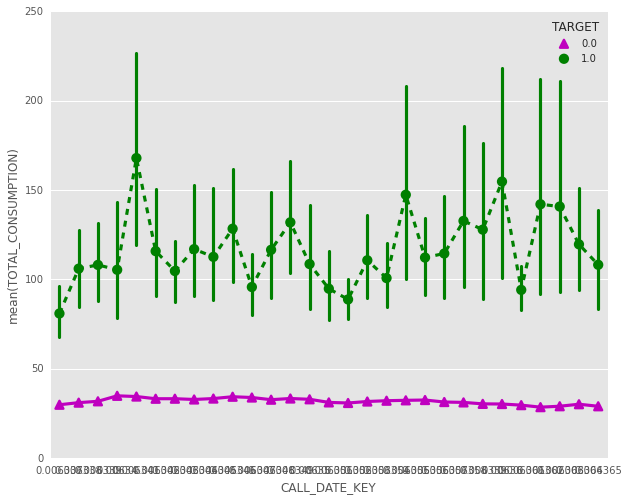

In [430]:
sns.pointplot(x="CALL_DATE_KEY", y="TOTAL_CONSUMPTION", hue="TARGET", data=g,
              palette={1: "g", 0: "m"},
              markers=["^", "o"], linestyles=["-", "--"]);

In [481]:
s = daily.groupby("CONTRACT_KEY", as_index=False).agg(np.median)
s = train_ready.merge(s, on="CONTRACT_KEY", how="left")

In [449]:
s = daily.merge(train).groupby("CONTRACT_KEY", as_index=False).agg(np.median)
s["TOTAL_CONSUMPTION"] = s["TOTAL_CONSUMPTION"].apply(lambda x: x / 1000000.0)

In [483]:
s["HOBA"] = 0
s["HOBA"] = (s["TOTAL_CONSUMPTION"] > 100).apply(lambda x: 1 if x else 0)

In [ ]:
r = s[s["HOBA"]]

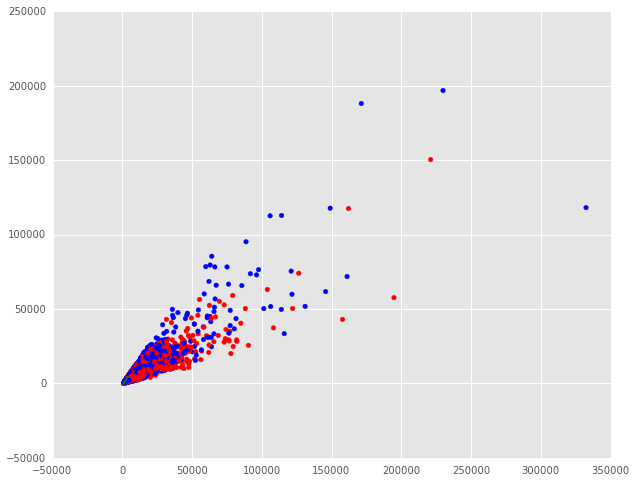

In [496]:
plt.scatter(r["211_USAGE"].values, r["MEAN"], color = 
           map(lambda x: 'r' if x else 'b', r['TARGET'].values))
plt.plot(range(0, 5000, 1000), map(lambda x: (x - 800) / 0.7, range(0, 5000, 1000)), color='g')

In [313]:
train_ready["HOBA_EX"] = train_ready["211_USAGE"] > train_ready['MEAN']

In [332]:
train_ready["F"] = (train_ready["HOBA_EX"]) & (train_ready["APPLE"])

In [872]:
train_ready.groupby(["APPLE", "NEW"]).mean()["TARGET"]

APPLE  NEW  
False  False    0.104140
       True     0.418465
True   False    0.252777
       True     0.513789
Name: TARGET, dtype: float64

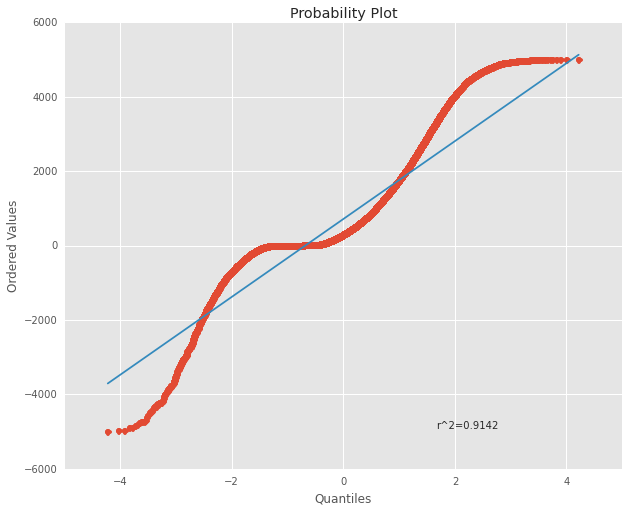

In [49]:
import pylab 
import scipy.stats as stats
 
s = train_ready[(train_ready["TARGET"] == 0) & (train_ready["211_USAGE"] < 5000) & (train_ready["211_USAGE"] > -5000)]["211_USAGE"]
# s = np.random.normal(loc = 20, scale = 5, size=100) 
stats.probplot(s, dist="norm", plot=pylab)
pylab.show()

In [83]:
tar_1 = train_ready[(train_ready["TARGET"] == 1) & (train_ready["MEAN"] < 5000)]["MEAN"].values
tar_0 = train_ready[(train_ready["TARGET"] == 0) & (train_ready["MEAN"] < 5000)]["MEAN"].values
values_1, base_1 = np.histogram(tar_1)
values_0, base_0 = np.histogram(tar_0)
tar_1 = np.cumsum(values_0)
tar_0 = np.cumsum(values_0)

In [195]:
train_ready["PTARGET"]

,CONTRACT_KEY,206_SESSION_COUNT,206_USAGE,207_SESSION_COUNT,207_USAGE,208_SESSION_COUNT,208_USAGE,209_SESSION_COUNT,209_USAGE,210_SESSION_COUNT,...,RATE_PLAN=Vodafone Business,RATE_PLAN=Vodafone Easy,RATE_PLAN=Vodafone Easy 150,RATE_PLAN=Vodafone Easy 50,RATE_PLAN=Vodafone line bronze bundle,APPLE,GALAXY,NEW,s_NEW,m_500
0,142404951,3581,4405,3392,5598,3337,5864,3614,5541,2999,...,0,0,0,0,0,True,False,False,False,False
1,142404952,962,4594,1341,2229,1146,3980,2210,2905,2835,...,0,0,0,0,0,False,True,False,True,False
2,142405010,466,2520,467,2141,582,1909,583,3735,569,...,0,0,0,0,0,False,False,True,False,False
3,142405022,875,4032,675,3756,682,4283,579,3505,1000,...,0,0,0,1,0,False,False,False,False,False
4,142405038,728,4119,352,3235,555,2873,102,580,489,...,0,0,0,0,0,False,False,False,False,False
5,142405136,25,4,21,4,52,176,278,1084,338,...,0,0,0,0,0,False,False,True,False,True
6,142405146,1004,471,1174,398,1172,506,1706,514,371,...,0,0,0,0,0,True,False,False,False,True
7,142405192,131,783,189,1248,193,1139,179,1688,168,...,0,0,0,0,0,False,True,False,False,False
8,142405204,332,2669,367,1718,775,2034,836,703,844,...,0,0,1,0,0,True,False,False,False,False
9,142405304,595,4733,476,2901,334,1028,381,356,338,...,0,0,0,0,0,False,True,False,False,False
